In [1]:
%matplotlib notebook

from IPython.display import Image
from simplify.face_lattice import *
from simplify.simplify import *
from simplify.plot import *
from simplify.homothety import *
from islpy import *
from IPython.display import Image
import networkx as nx
import graphviz as gv
from islplot.support import *
import islplot.plotter as islp

## Summary

I have everything working for both the constant and parametric cases, modulo the exit condition for similarity (this needs some tweaks, see examples 6 and 7 below). 

Below are 10 different examples illustrating all of the different scenarios. Given the way that I'm making cuts now, I think it will **always** terminate, though I'm still thinking through how to prove/show this. We should discuss this more on Thursday when we meet.

### Changes since last week

Last week, we discussed how it is impossible to construct a single hyperplane containing multiple parametric vertices when there is more than one parameter and there are no equality constraints between parameters (i.e., one param is a constant multiple of the other). Consequently, we cannot make cuts through multiple vertices when parameters are specified. 

* instead of making cuts through multiple vertices, I only use a single vertex. When there is ambiguity in the choice of orientation of the cut (i.e., when constructing the $d$ dimensional hyperplane from a $k$ dimensional basis, with $d-k > 0$), I use $d-k$ additional linearly independent basis vectors from the principle axes (i.e., $\hat{i}$, $\hat{j}$, $\hat{k}$, ...) instead of trying to construct additional basis vectors from pairs of vertices.
* now I'm checking all chambers when splitting since the vertices are different in each chamber, and consequently the possible splits are different. Given a cut at a vertex, recursion on all chambers of the children needs to succeed before the cut is considered successful. This is implemented currently.
* I implemented a similarity check (looser than the previous homothety check), by just looking at the index coefficients across all constraints. If these are the same between two sets, then the sets are considered similar.
* the plotting code below now selects from the appropriate chamber based on the particular values of parameters specified. The main simplification still processes all chambers but the picture looks different based on the parameter values. Compare examples 3 and 4 below. We're not doing this now, but when code generation happens, we'll need to generate different code for each combination of chambers down the successful splits.

## Main Algorithm

Consider an input reduction expression with:
* polyhedron $P$ with $d$ indices, $q$ parameters, and $e$ equality constraints representing the context domain (for simplicity here, let $e=0$)
* projection function $f_{p}: Z^{d} \rightarrow Z^{d-k}$
* dependence function $f_{d}: Z^{d} \rightarrow Z^{d-l}$  (there are $l$ dimensions of reuse)
* face lattice, $L$, of $P$

Call `simplify(L.root, fp, fd, l, L)`


### `simplify(node, fp, fd, l, lattice):`

1. if current sub-problem is similar to an ancestor **and** there are no more critical vertices to process then return success
1. if there are no more available dimensions of reuse then return success (i.e., $l=0$)
1. construct feasible reuse space for each possible labeling, given $f_p$ and $f_d$. Then select a $\rho$, recurse into all necessary facets of node; i.e., call `simplify(facet, fp, fd, l-1, lattice)` for each facet. If all facets succeed, report success and $\rho$.
1. if previous step fails, construct list of splitting affine expressions. For each split, build a new face-lattice for each chamber (`c`) for each half (`h`), and recurse; call `simplify(half, fp, fd, l, c_h_lattice)` for each. If all chambers in both halfs succeed, report success and affine expression. See next section for details on how to split.
1. if previous step fails, do reduction decomposition ($f_{p} = f_{p}'' \circ f_{p}'$) to transform each weak boundary facet into a strict boundary facet and recurse on node again; i.e., call `simplify(node, fp', fd, l)` for each $f_{p}'$. If recusion returns success, report $f_{p}'$.

### How to split

Split to introduce either new strict boundary facets (i.e., along $f_{p}$) or invariant facets (i.e., along $f_{d}$).

For a particular facet in the lattice, **given**:
* function $f: Z^{d} \rightarrow Z^{d-k}$
* vertices $V$ of the facet (where there are $N_{V}$ vertices)

**Want**: construct the affine expression characterizing the split through a single parametric vertex. There are at most $2N_{V}$ candidate splits.

**How**: construct the ($d-1$)-dimensional polyhedron from:
* null space of the (projection or dependence) function, $\rm{ker}(f)$ 
* one vertex of the facet
* as many additional basis vectors from pricipal axes as needed

Then obtain the affine expression from this polyhedron's single equality constraint.

The order in we process vertices is important. TODO - describe the notion of a **critical** vertex.

**Procedure** to obtain list of candidate splits:  
For each vertex $v$ in $V$:
1. $S_{0} \leftarrow $ the $k$-dimensional set from $\rm{ker}(f)$
1. $m \leftarrow $ map from origin to the vertex $v$
1. if rank of $S_{0}$ is $d-1$, then save $T_{0} \leftarrow S_{0}$ and go to step 5
1. for each combo of $d-k-1$ basis vectors:
  1. $T_{i} \leftarrow \rm{hull}(S_{0} \cup ($set spanned by the $i$'th combo$))$
  1. if rank of $T_{i}$ is $d-1$ then save $T_{i}$ else discard it
1. for each saved $T_{i}$:
  1. $U_{i} \leftarrow m(T_{i})$
  1. $\rm{aff}_{i} \leftarrow$ affine expression of $U_{i}$'s single equality constraint
  1. save $\rm{aff}_{i}$

Return all saved $\rm{aff}_{i}$ for all vertices. 

For each candidate split, produce two halves of $P$. If each half is non-empty, then consider this a good candidate split.

# 1) Simplest 2D parallelogram - constant (non-parametric)

constraints:
c0	[[-1  1 10]	{ [i, j] : 10 - i + j >= 0 }
c1	 [ 0  1  0]	{ [i, j] : j >= 0 }
c2	 [ 0 -1 15]	{ [i, j] : 15 - j >= 0 }
c3	 [ 1 -1  0]]	{ [i, j] : i - j >= 0 }

Simplifications
@{}:@{}, {[i,j]->[i]} :: Action.INDEX_SET_SPLIT at { [i, j] -> [(-10 + i)] }
  L.0@{}:@{}, {[i,j]->[i]} :: Action.RHO, { [1, 0] } 
    @{}:@{1}, {[i,j]->[i]} :: Action.NONE 
  R.0@{}:@{}, {[i,j]->[i]} :: Action.INDEX_SET_SPLIT at { [i, j] -> [(-10 + j)] }
    L.0@{}:@{}, {[i,j]->[i]} :: Action.RHO, { [-1, 0] } 
      @{}:@{1}, {[i,j]->[i]} :: Action.NONE 
    R.0@{}:@{}, {[i,j]->[i]} :: Action.SIMILARITY 
      @{}:@{}, {[i,j]->[i]} :: Action.NONE 


<IPython.core.display.Javascript object>


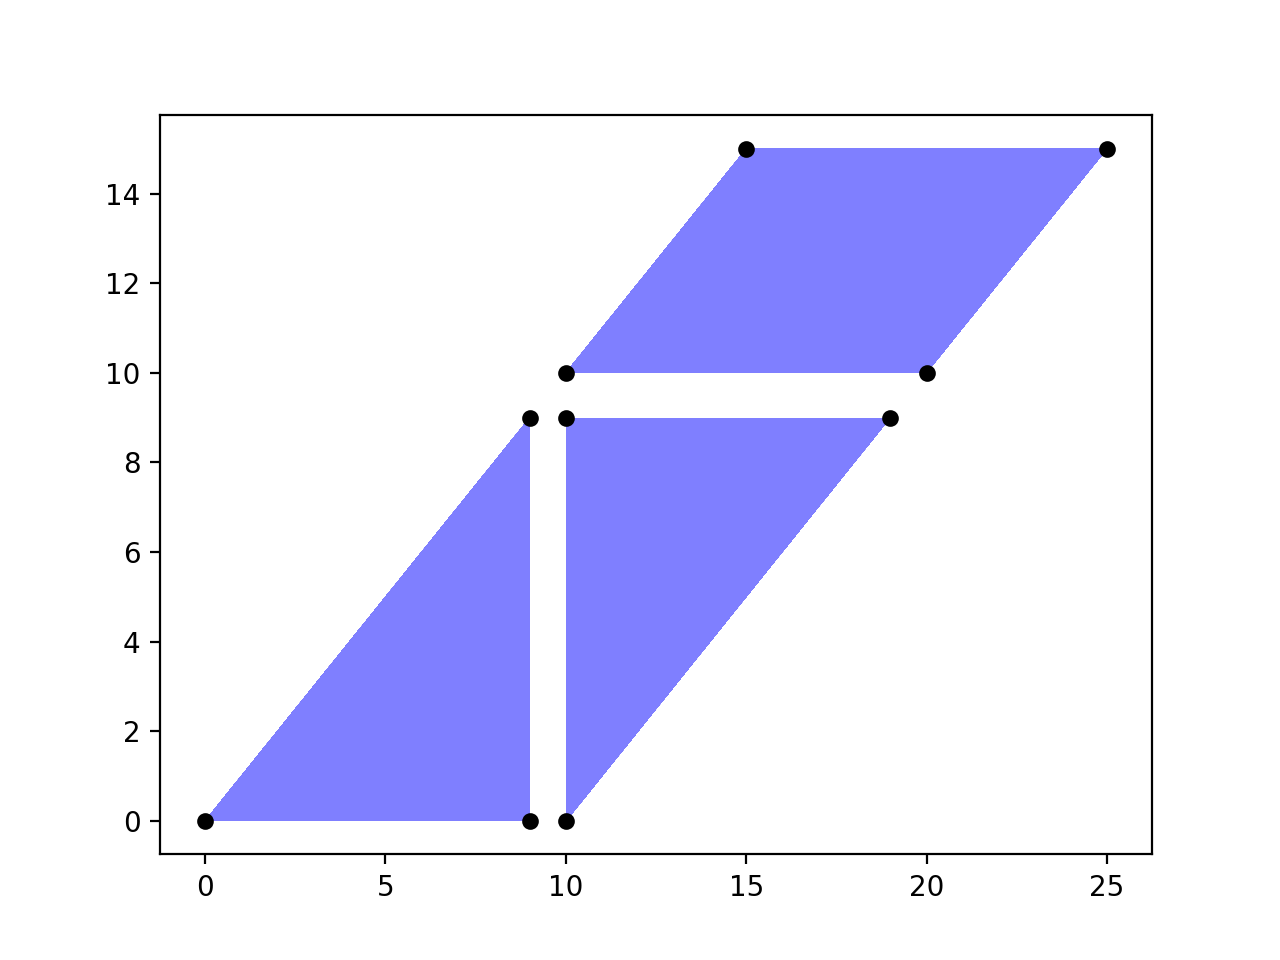

In [2]:
# simplest 2D parallelogram
op = 'max'
fp = '{[i,j]->[i]}'
fd = '{[i,j]->[j]}'
s = '{[i,j] : 0<=j and i-10<=j and j<=i and j<=15 }'

successes = start(op, fp, s, fd, verbose=False, report_all=False)

fig = islp._plt.figure()
for success in successes:
    S = None
    for P in success.get_splits(result=set()):
        islp.plot_bset_shape(P, figure=fig)

# 2) Simplest 2D parallelogram - one parameter

constraints:
c0	[[ 0  1  0  0]	[N] -> { [i, j] : j >= 0 }
c1	 [-1  1  1  0]	[N] -> { [i, j] : N - i + j >= 0 }
c2	 [ 1 -1  0  0]	[N] -> { [i, j] : i - j >= 0 }
c3	 [ 0 -1  4  0]]	[N] -> { [i, j] : 4N - j >= 0 }

Simplifications
@{}:@{}, [N]->{[i,j]->[i]} :: Action.INDEX_SET_SPLIT at [N] -> { [i, j] -> [(-N + i)] }
  L.0@{}:@{}, [N]->{[i,j]->[i]} :: Action.RHO, [N = 0] -> { [1, 0] } 
    @{}:@{0}, [N]->{[i,j]->[i]} :: Action.NONE 
  R.0@{}:@{}, [N]->{[i,j]->[i]} :: Action.INDEX_SET_SPLIT at [N] -> { [i, j] -> [(-N + j)] }
    L.0@{}:@{}, [N]->{[i,j]->[i]} :: Action.RHO, [N = 0] -> { [-1, 0] } 
      @{}:@{2}, [N]->{[i,j]->[i]} :: Action.NONE 
    R.0@{}:@{}, [N]->{[i,j]->[i]} :: Action.SIMILARITY 
      @{}:@{}, [N]->{[i,j]->[i]} :: Action.NONE 


<IPython.core.display.Javascript object>


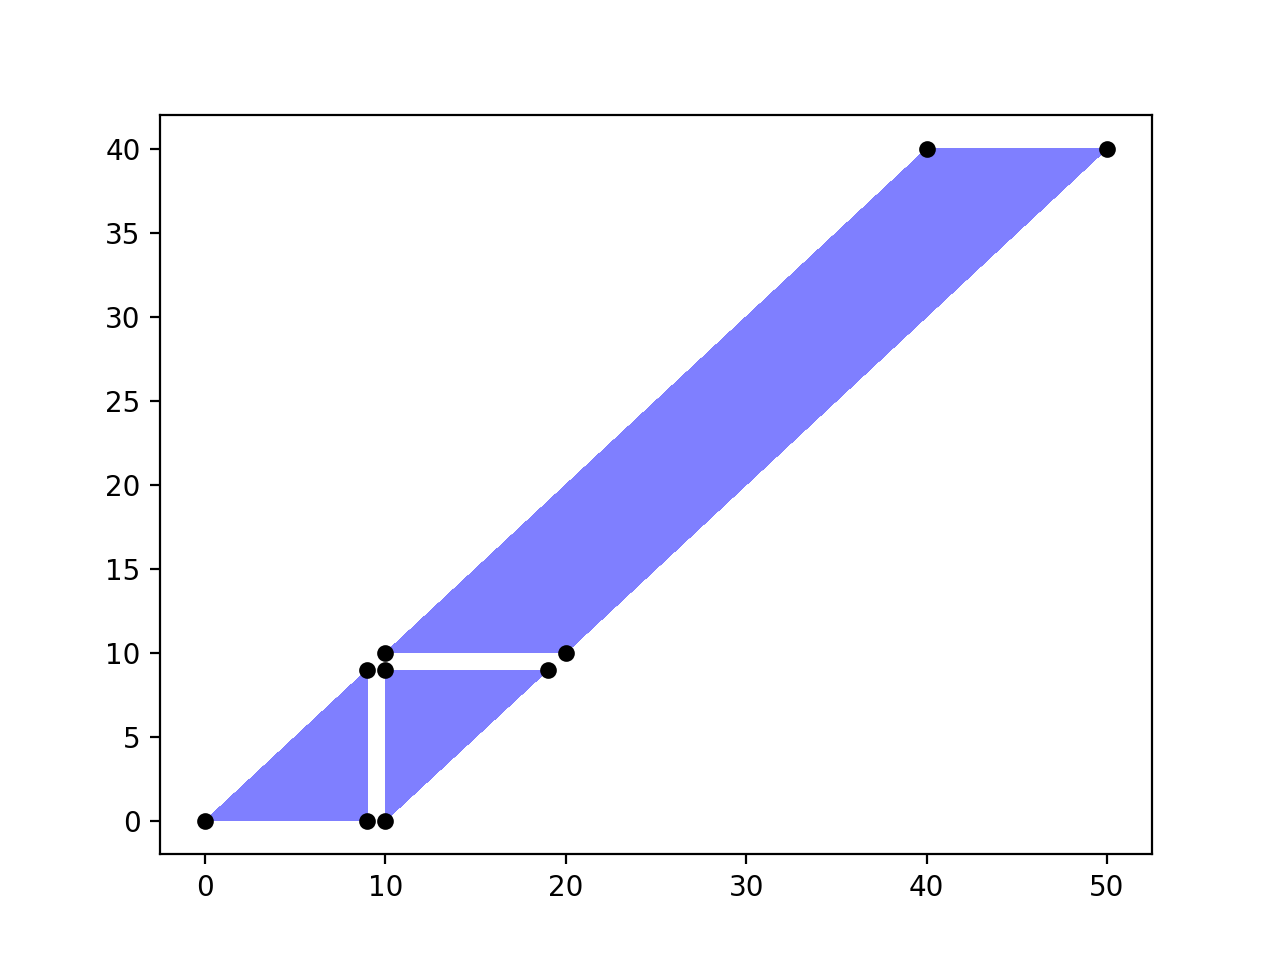

[N] -> { [i, j] : j >= N and -N + i <= j <= i and j <= 4N }
[N] -> { [i, j] : i >= N and -N + i <= j < N }
[N] -> { [i, j] : i < N and 0 <= j <= i }


In [3]:
# simplest parametric 2D parallelogram
op = 'max'
fp = '[N]->{[i,j]->[i]}'
fd = '[N]->{[i,j]->[j]}'
s = '[N]->{[i,j] : 0<=j and i-N<=j and j<=i and j<=4N }'
dom = BasicSet('[N]->{[i,j] : N=10 }')

successes = start(op, fp, s, fd, verbose=False, report_all=False)

fig = islp._plt.figure()
for success in successes:
    S = None
    for P in success.get_splits(result=set(), params=dom):
        print(P)
        islp.plot_bset_shape(P.intersect(dom), figure=fig)

# 3) Simplest 2D parallelogram - two parameters (M>N)

constraints:
c0	[[ 0  1  0  0  0]	[M, N] -> { [i, j] : j >= 0 }
c1	 [-1  1  0  1  0]	[M, N] -> { [i, j] : N - i + j >= 0 }
c2	 [ 1 -1  0  0  0]	[M, N] -> { [i, j] : i - j >= 0 }
c3	 [ 0 -1  1  0  0]]	[M, N] -> { [i, j] : M - j >= 0 }

Simplifications
@{}:@{}, [M,N]->{[i,j]->[i]} :: Action.INDEX_SET_SPLIT at [M, N] -> { [i, j] -> [(-N + i)] }
  L.0@{}:@{}, [M,N]->{[i,j]->[i]} :: Action.RHO, [M = 0, N = 0] -> { [1, 0] } 
    @{}:@{3}, [M,N]->{[i,j]->[i]} :: Action.NONE 
  L.1@{}:@{}, [M,N]->{[i,j]->[i]} :: Action.RHO, [M = 0, N = 0] -> { [1, 0] } 
    @{}:@{3}, [M,N]->{[i,j]->[i]} :: Action.NONE 
  R.0@{}:@{}, [M,N]->{[i,j]->[i]} :: Action.RHO, [M = 0, N = 0] -> { [-1, 0] } 
    @{}:@{2}, [M,N]->{[i,j]->[i]} :: Action.NONE 
  R.1@{}:@{}, [M,N]->{[i,j]->[i]} :: Action.INDEX_SET_SPLIT at [M, N] -> { [i, j] -> [(-N + j)] }
    L.0@{}:@{}, [M,N]->{[i,j]->[i]} :: Action.RHO, [M = 0, N = 0] -> { [-1, 0] } 
      @{}:@{3}, [M,N]->{[i,j]->[i]} :: Action.NONE 
    R.0@{}:@{}, [M,N]->{[i,j]->[i]} 

<IPython.core.display.Javascript object>


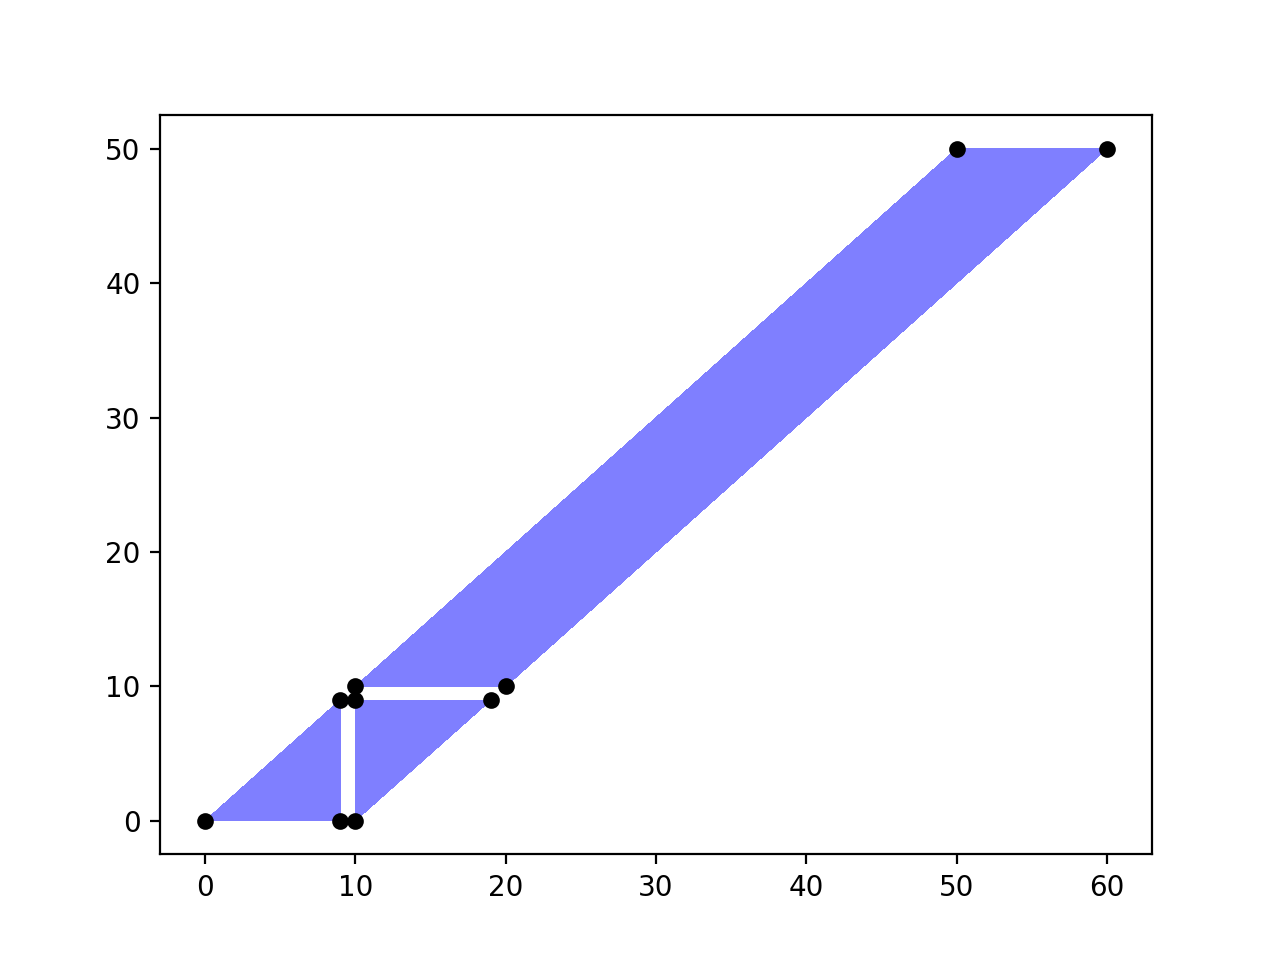

In [4]:
# simplest parametric 2D parallelogram
op = 'max'
fp = '[M,N]->{[i,j]->[i]}'
fd = '[M,N]->{[i,j]->[j]}'
s = '[M,N]->{[i,j] : 0<=j and i-N<=j and j<=i and j<=M }'
dom = BasicSet('[M,N]->{[i,j] : N=10 and M=50 }')

successes = start(op, fp, s, fd, verbose=False, report_all=False)

fig = islp._plt.figure()
for success in successes:
    S = None
    for P in success.get_splits(result=set(), params=dom):
        islp.plot_bset_shape(P.intersect(dom), figure=fig)

# 4) Simplest 2D parallelogram - two parameters different chamber (M<N)

constraints:
c0	[[ 0  1  0  0  0]	[M, N] -> { [i, j] : j >= 0 }
c1	 [-1  1  0  1  0]	[M, N] -> { [i, j] : N - i + j >= 0 }
c2	 [ 1 -1  0  0  0]	[M, N] -> { [i, j] : i - j >= 0 }
c3	 [ 0 -1  1  0  0]]	[M, N] -> { [i, j] : M - j >= 0 }

Simplifications
@{}:@{}, [M,N]->{[i,j]->[i]} :: Action.INDEX_SET_SPLIT at [M, N] -> { [i, j] -> [(-N + i)] }
  L.0@{}:@{}, [M,N]->{[i,j]->[i]} :: Action.RHO, [M = 0, N = 0] -> { [1, 0] } 
    @{}:@{3}, [M,N]->{[i,j]->[i]} :: Action.NONE 
  L.1@{}:@{}, [M,N]->{[i,j]->[i]} :: Action.RHO, [M = 0, N = 0] -> { [1, 0] } 
    @{}:@{3}, [M,N]->{[i,j]->[i]} :: Action.NONE 
  R.0@{}:@{}, [M,N]->{[i,j]->[i]} :: Action.RHO, [M = 0, N = 0] -> { [-1, 0] } 
    @{}:@{2}, [M,N]->{[i,j]->[i]} :: Action.NONE 
  R.1@{}:@{}, [M,N]->{[i,j]->[i]} :: Action.INDEX_SET_SPLIT at [M, N] -> { [i, j] -> [(-N + j)] }
    L.0@{}:@{}, [M,N]->{[i,j]->[i]} :: Action.RHO, [M = 0, N = 0] -> { [-1, 0] } 
      @{}:@{3}, [M,N]->{[i,j]->[i]} :: Action.NONE 
    R.0@{}:@{}, [M,N]->{[i,j]->[i]} 

<IPython.core.display.Javascript object>


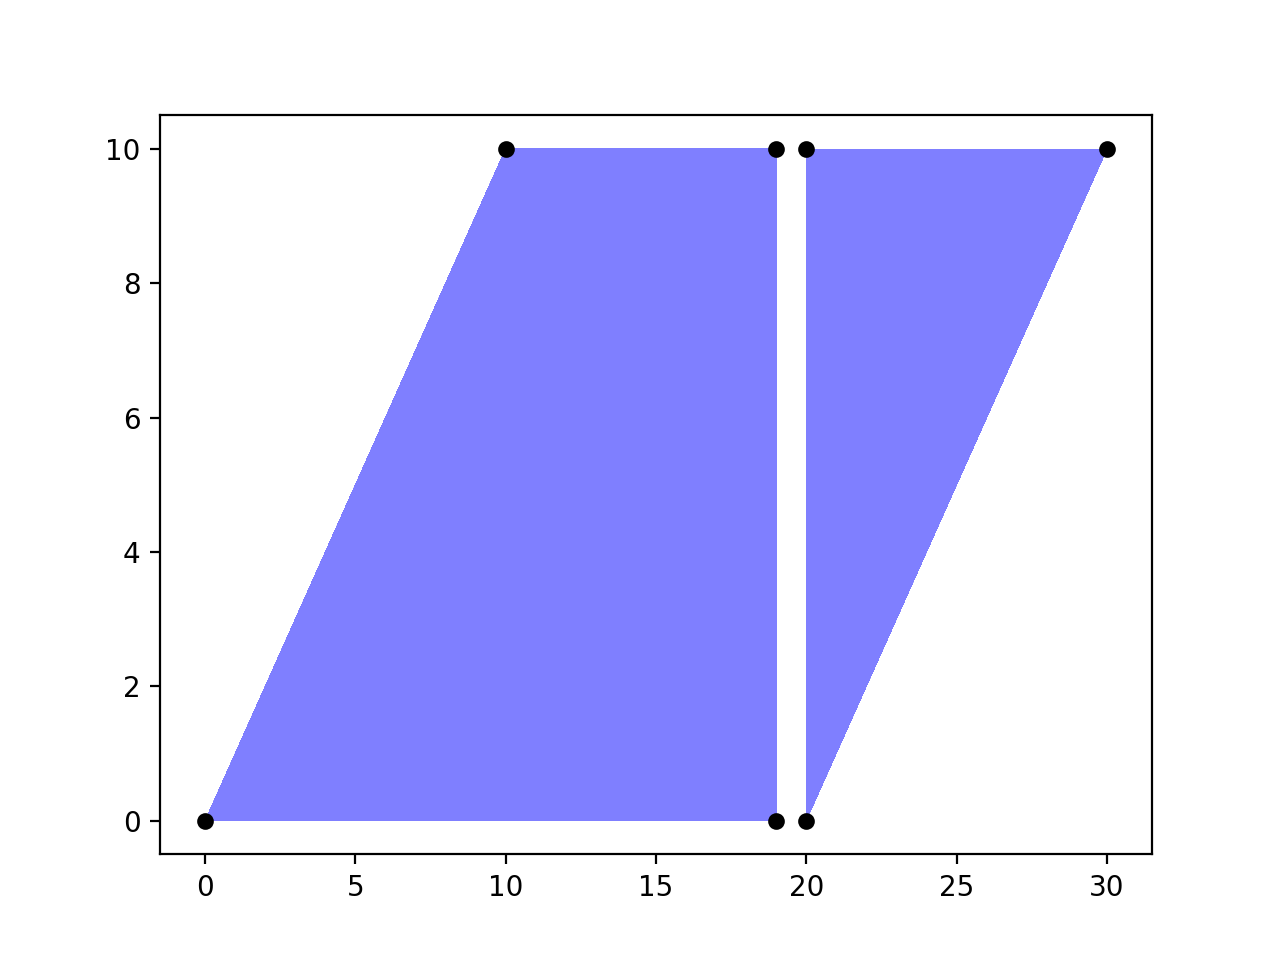

In [5]:
# simplest parametric 2D parallelogram
op = 'max'
fp = '[M,N]->{[i,j]->[i]}'
fd = '[M,N]->{[i,j]->[j]}'
s = '[M,N]->{[i,j] : 0<=j and i-N<=j and j<=i and j<=M }'
dom = BasicSet('[M,N]->{[i,j] : N=20 and M=10 }')

successes = start(op, fp, s, fd, verbose=False, report_all=False)

fig = islp._plt.figure()
for success in successes:
    S = None
    for P in success.get_splits(result=set(), params=dom):
        islp.plot_bset_shape(P.intersect(dom), figure=fig)

# 5) Simplest 2D parallelogram - oblique projection function

constraints:
c0	[[ 0  1  0  0]	[N] -> { [i, j] : j >= 0 }
c1	 [-1  1  1  0]	[N] -> { [i, j] : N - i + j >= 0 }
c2	 [ 1 -1  0  0]	[N] -> { [i, j] : i - j >= 0 }
c3	 [ 0 -2  3  0]]	[N] -> { [i, j] : 3N - 2j >= 0 }

Simplifications
@{}:@{}, [N]->{[i,j]->[i+j]} :: Action.INDEX_SET_SPLIT at [N] -> { [i, j] -> [(-N + i + j)] }
  L.0@{}:@{}, [N]->{[i,j]->[i+j]} :: Action.RHO, [N = 0] -> { [1, 0] } 
    @{}:@{2}, [N]->{[i,j]->[i+j]} :: Action.NONE 
  R.0@{}:@{}, [N]->{[i,j]->[i+j]} :: Action.INDEX_SET_SPLIT at [N] -> { [i, j] -> [(-N + 2j)] }
    L.0@{}:@{}, [N]->{[i,j]->[i+j]} :: Action.RHO, [N = 0] -> { [-1, 0] } 
      @{}:@{2}, [N]->{[i,j]->[i+j]} :: Action.NONE 
    R.0@{}:@{}, [N]->{[i,j]->[i+j]} :: Action.INDEX_SET_SPLIT at [N] -> { [i, j] -> [(-2N + i + j)] }
      L.0@{}:@{}, [N]->{[i,j]->[i+j]} :: Action.RHO, [N = 0] -> { [-1, 0] } 
        @{}:@{}, [N]->{[i,j]->[i+j]} :: Action.NONE 
      R.0@{}:@{}, [N]->{[i,j]->[i+j]} :: Action.SIMILARITY 
        @{}:@{}, [N]->{[i,j]->[i+j]} :: 

<IPython.core.display.Javascript object>


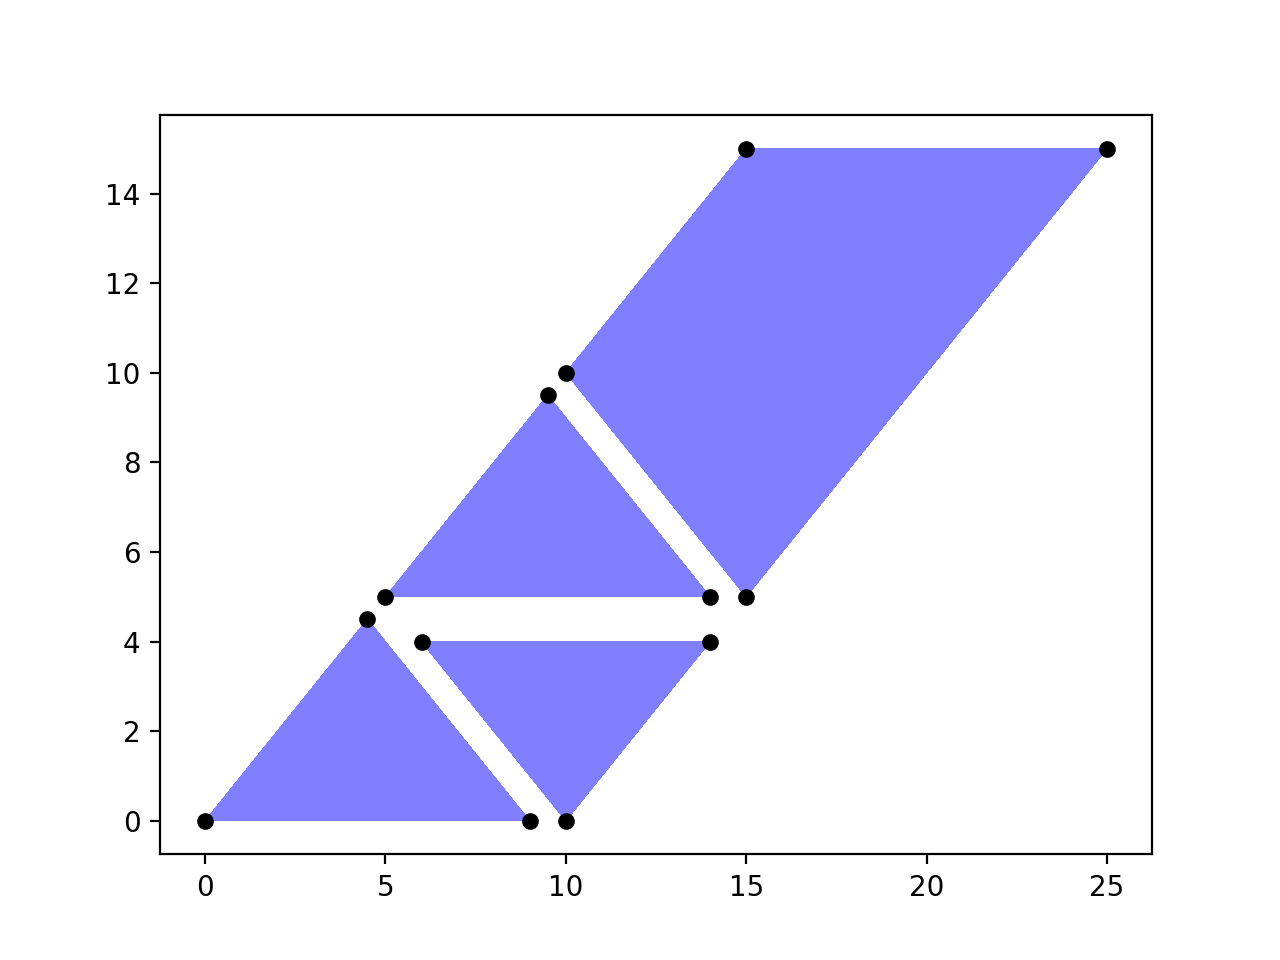

In [6]:
# simplest parametric 2D parallelogram
op = 'max'
fp = '[N]->{[i,j]->[i+j]}'
fd = '[N]->{[i,j]->[j]}'
s = '[N]->{[i,j] : 0<=j and i-N<=j and j<=i and j<=3N/2 }'
dom = BasicSet('[N]->{[i,j] : N=10 }')

successes = start(op, fp, s, fd, verbose=False, report_all=False)

fig = islp._plt.figure()
for success in successes:
    S = None
    for P in success.get_splits(result=set(), params=dom):
        islp.plot_bset_shape(P.intersect(dom), figure=fig)

# 6) Less simple 2D example - constant (non-parametric)

constraints:
c0	[[-1  1 10]	{ [i, j] : 10 - i + j >= 0 }
c1	 [ 0  1  0]	{ [i, j] : j >= 0 }
c2	 [ 1 -1  0]	{ [i, j] : i - j >= 0 }
c3	 [ 1 -2 14]]	{ [i, j] : 14 + i - 2j >= 0 }

Simplifications
@{}:@{}, {[i,j]->[i]} :: Action.INDEX_SET_SPLIT at { [i, j] -> [(-14 + i)] }
  L.0@{}:@{}, {[i,j]->[i]} :: Action.INDEX_SET_SPLIT at { [i, j] -> [(-3 + j)] }
    L.0@{}:@{}, {[i,j]->[i]} :: Action.INDEX_SET_SPLIT at { [i, j] -> [(-2 + i)] }
      L.0@{}:@{}, {[i,j]->[i]} :: Action.RHO, { [1, 0] } 
        @{}:@{1}, {[i,j]->[i]} :: Action.NONE 
      R.0@{}:@{}, {[i,j]->[i]} :: Action.RHO, { [-1, 0] } 
        @{}:@{1}, {[i,j]->[i]} :: Action.NONE 
    R.0@{}:@{}, {[i,j]->[i]} :: Action.RHO, { [1, 0] } 
      @{}:@{1}, {[i,j]->[i]} :: Action.NONE 
  R.0@{}:@{}, {[i,j]->[i]} :: Action.INDEX_SET_SPLIT at { [i, j] -> [(-14 + j)] }
    L.0@{}:@{}, {[i,j]->[i]} :: Action.RHO, { [-1, 0] } 
      @{}:@{1}, {[i,j]->[i]} :: Action.NONE 
    R.0@{}:@{}, {[i,j]->[i]} :: Action.INDEX_SET_SPLIT at { [i, j] ->

<IPython.core.display.Javascript object>


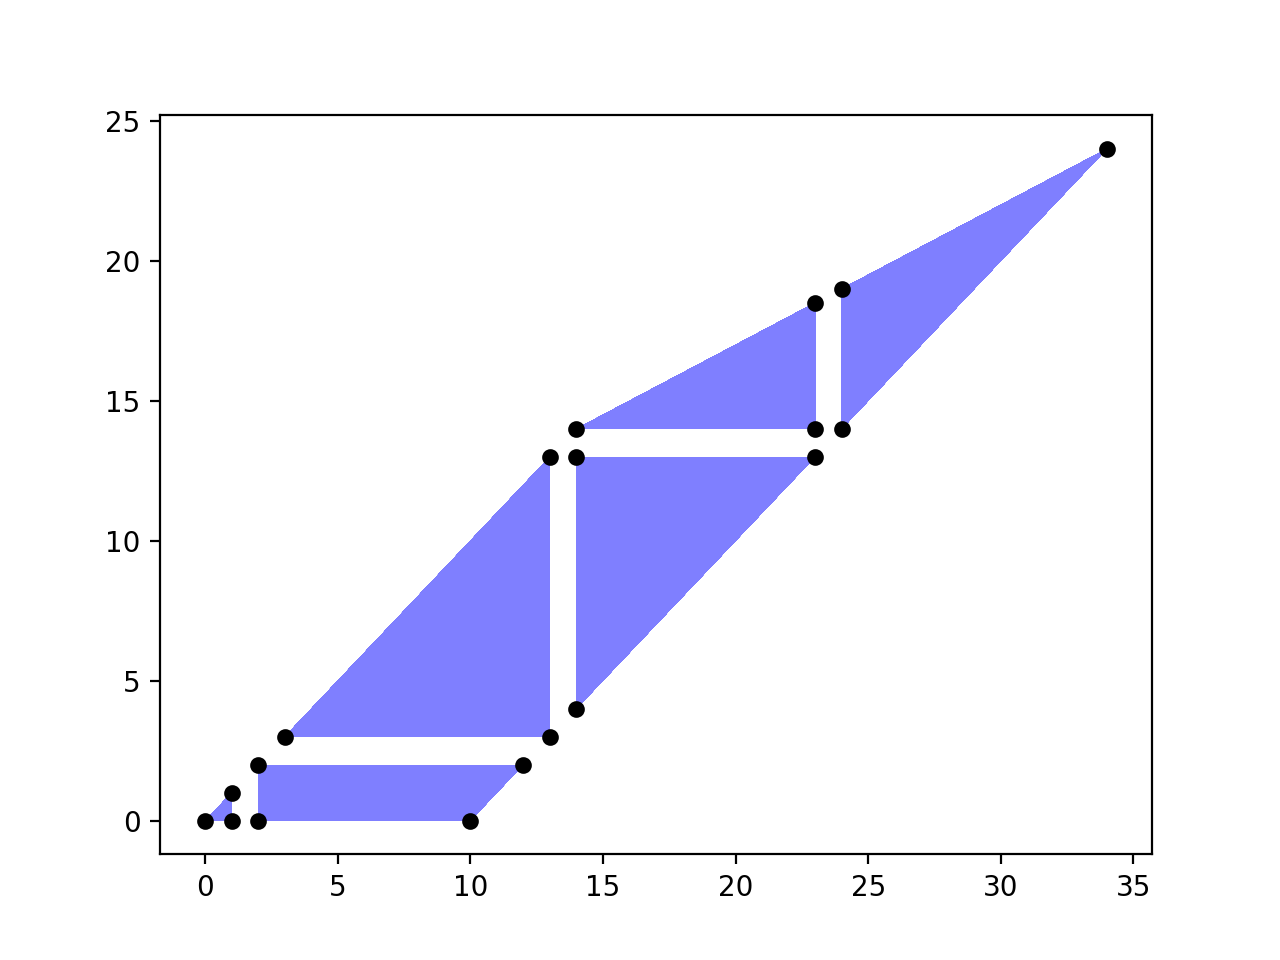

In [7]:
# slightly less simple 2D example
op = 'max'
fp = '{[i,j]->[i]}'
fd = '{[i,j]->[j]}'
s = '{[i,j] : 0<=j and i-10<=j and j<=i and 2j<=i+14 }'

successes = start(op, fp, s, fd, verbose=False, report_all=False)

fig = islp._plt.figure()
for success in successes:
    S = None
    for P in success.get_splits(result=set()):
        islp.plot_bset_shape(P, figure=fig)

# 7) Less simple 2D example - parametric

constraints:
c0	[[ 0  1  0  0]	[N] -> { [i, j] : j >= 0 }
c1	 [-1  1  1  0]	[N] -> { [i, j] : N - i + j >= 0 }
c2	 [ 1 -1  0  0]	[N] -> { [i, j] : i - j >= 0 }
c3	 [ 2 -4  3  0]]	[N] -> { [i, j] : 3N + 2i - 4j >= 0 }

Simplifications
@{}:@{}, [N]->{[i,j]->[i]} :: Action.INDEX_SET_SPLIT at [N] -> { [i, j] -> [(-3N + 2i)] }
  L.0@{}:@{}, [N]->{[i,j]->[i]} :: Action.INDEX_SET_SPLIT at [N] -> { [i, j] -> [(1 - N + 2j)] }
    L.0@{}:@{}, [N]->{[i,j]->[i]} :: Action.INDEX_SET_SPLIT at [N] -> { [i, j] -> [(2 - N + 2i)] }
      L.0@{}:@{}, [N]->{[i,j]->[i]} :: Action.RHO, [N = 0] -> { [1, 0] } 
        @{}:@{0}, [N]->{[i,j]->[i]} :: Action.NONE 
      R.0@{}:@{}, [N]->{[i,j]->[i]} :: Action.RHO, [N = 0] -> { [-1, 0] } 
        @{}:@{3}, [N]->{[i,j]->[i]} :: Action.NONE 
    R.0@{}:@{}, [N]->{[i,j]->[i]} :: Action.RHO, [N = 0] -> { [1, 0] } 
      @{}:@{2}, [N]->{[i,j]->[i]} :: Action.NONE 
  L.1@{}:@{}, [N]->{[i,j]->[i]} :: Action.RHO, [N = 0] -> { [1, 0] } 
    @{}:@{0}, [N]->{[i,j]->[i]} :: 

<IPython.core.display.Javascript object>


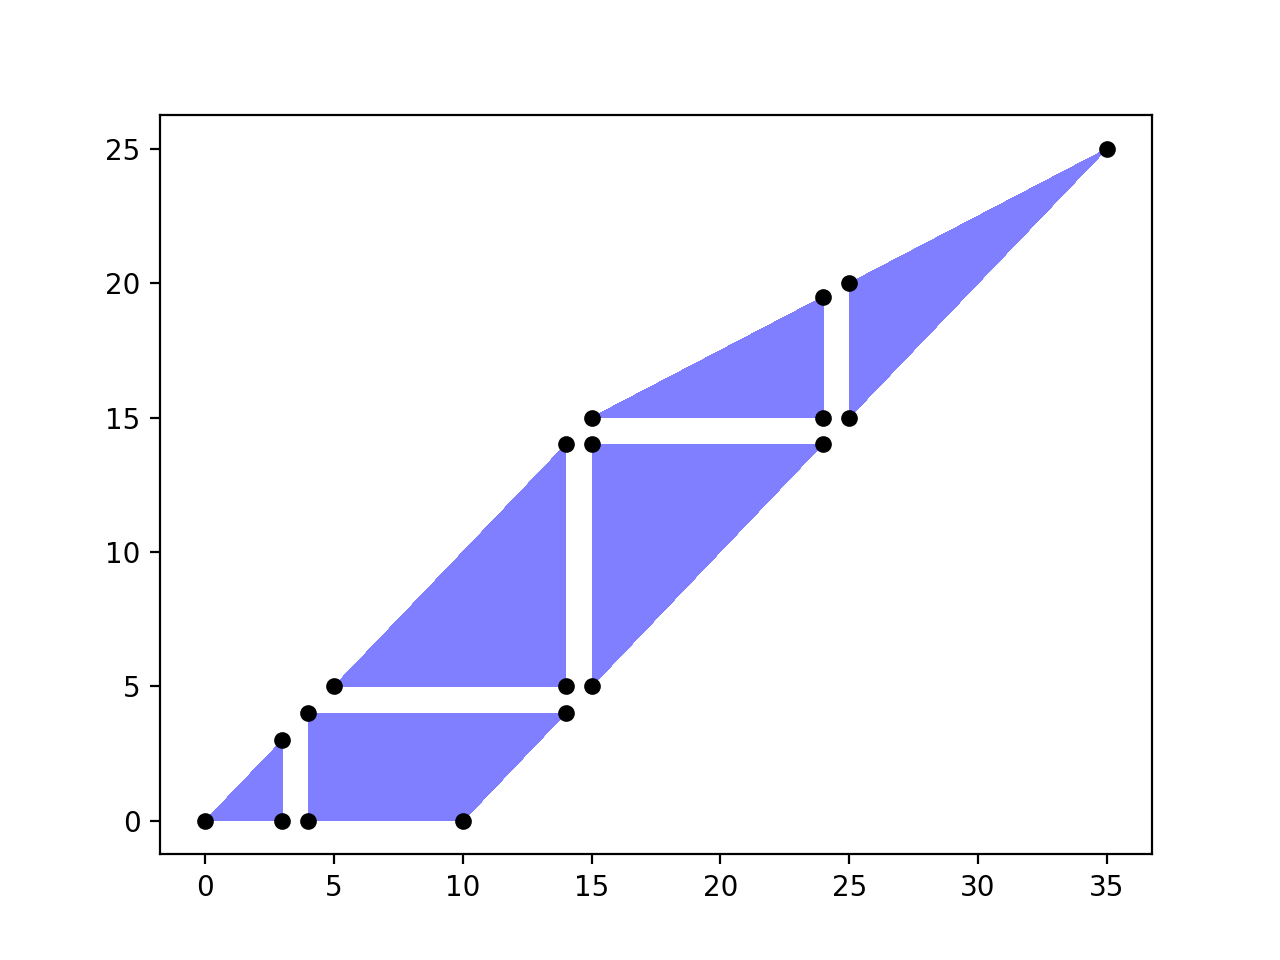

In [8]:
# slightly less simple parametric 2D example
op = 'max'
fp = '[N]->{[i,j]->[i]}'
fd = '[N]->{[i,j]->[j]}'
s = '[N]->{[i,j] : 0<=j and i-N<=j and j<=i and 2j<=i+3N/2 }'

dom = BasicSet('[N]->{[i,j] : N=10 }')

successes = start(op, fp, s, fd, verbose=False, report_all=False)

fig = islp._plt.figure()
for success in successes:
    S = None
    for P in success.get_splits(result=set(), params=dom):
        islp.plot_bset_shape(P.intersect(dom), figure=fig)

# 7.5) Less simple 2D example - parametric (M,N)

constraints:
c0	[[ 0  0  1 -1 -1]	[M, N] -> { [i, j] : -1 + M - N >= 0 }
c1	 [ 0  1  0  0  0]	[M, N] -> { [i, j] : j >= 0 }
c2	 [-1  1  0  1  0]	[M, N] -> { [i, j] : N - i + j >= 0 }
c3	 [ 1 -1  0  0  0]	[M, N] -> { [i, j] : i - j >= 0 }
c4	 [ 1 -2  1  0  0]]	[M, N] -> { [i, j] : M + i - 2j >= 0 }

Simplifications
@{}:@{}, [M,N]->{[i,j]->[i]} :: Action.INDEX_SET_SPLIT at [M, N] -> { [i, j] -> [(-M + i)] }
  L.0@{}:@{}, [M,N]->{[i,j]->[i]} :: Action.INDEX_SET_SPLIT at [M, N] -> { [i, j] -> [(1 - M + N + j)] }
    L.0@{}:@{}, [M,N]->{[i,j]->[i]} :: Action.INDEX_SET_SPLIT at [M, N] -> { [i, j] -> [(-N + i)] }
      L.0@{}:@{}, [M,N]->{[i,j]->[i]} :: Action.RHO, [M = 0, N = 0] -> { [1, 0] } 
        @{}:@{3}, [M,N]->{[i,j]->[i]} :: Action.NONE 
      L.1@{}:@{}, [M,N]->{[i,j]->[i]} :: Action.RHO, [M = 0, N = 0] -> { [1, 0] } 
        @{}:@{3}, [M,N]->{[i,j]->[i]} :: Action.NONE 
      R.0@{}:@{}, [M,N]->{[i,j]->[i]} :: Action.RHO, [M = 0, N = 0] -> { [-1, 0] } 
        @{}:@{2}, [M,N]->{[i

<IPython.core.display.Javascript object>


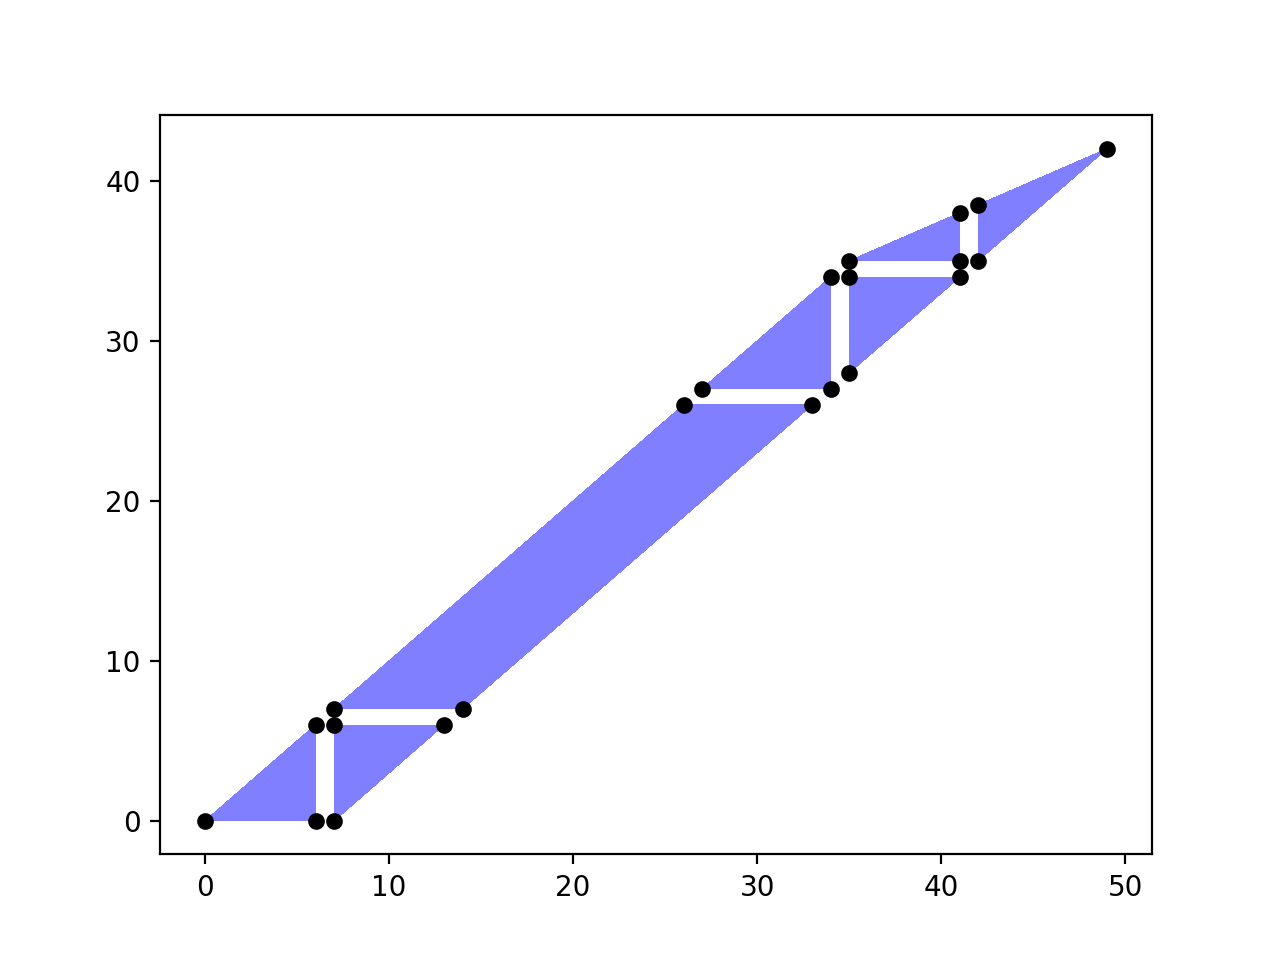

In [9]:
# slightly less simple parametric 2D example
op = 'max'
fp = '[M,N]->{[i,j]->[i]}'
fd = '[M,N]->{[i,j]->[j]}'
s = '[M,N]->{[i,j] : 0<=j and i-N<=j and j<=i and 2j<=i+M and M>N }'
# bug - this doesn't work if you remove the M>N constraint

dom = BasicSet('[M,N]->{[i,j] : N=7 and M=35 }')

successes = start(op, fp, s, fd, verbose=False, report_all=False)

fig = islp._plt.figure()
for success in successes:
    S = None
    for P in success.get_splits(result=set(), params=dom):
        islp.plot_bset_shape(P.intersect(dom), figure=fig)

## 8) 3D parallelpiped - constant (non-parametric)

There is something wrong here - what is a critical vertex at a 3D node?

constraints:
c0	[[-1  0  1 20]	{ [i, j, k] : 20 - i + k >= 0 }
c1	 [ 0 -1  1 20]	{ [i, j, k] : 20 - j + k >= 0 }
c2	 [ 0  0  1  0]	{ [i, j, k] : k >= 0 }
c3	 [ 0  0 -1 30]	{ [i, j, k] : 30 - k >= 0 }
c4	 [ 0  1 -1  0]	{ [i, j, k] : j - k >= 0 }
c5	 [ 1  0 -1  0]]	{ [i, j, k] : i - k >= 0 }

Simplifications
@{}:@{}, {[i,j,k]->[i]} :: Action.INDEX_SET_SPLIT at { [i, j, k] -> [(-20 + i)] }
  L.0@{}:@{}, {[i,j,k]->[i]} :: Action.DECOMPOSITION, {[i,j,k]->[-j + k,i]} on {2}
    @{}:@{}, {[i,j,k]->[-j + k,i]} :: Action.RHO, { [1, 0, 0] } 
      @{}:@{4}, {[i,j,k]->[-j + k,i]} :: Action.RHO, { [0, -1, 0] } 
        @{}:@{2, 4}, {[i,j,k]->[-j + k,i]} :: Action.NONE 
  R.0@{}:@{}, {[i,j,k]->[i]} :: Action.INDEX_SET_SPLIT at { [i, j, k] -> [(-20 + k)] }
    L.0@{}:@{}, {[i,j,k]->[i]} :: Action.DECOMPOSITION, {[i,j,k]->[-j + k,i]} on {4}
      @{}:@{}, {[i,j,k]->[-j + k,i]} :: Action.RHO, { [-1, 0, 0] } 
        @{}:@{1}, {[i,j,k]->[-j + k,i]} :: Action.RHO, { [0, -1, 0] } 
          @{}:@{1, 2}, 

<IPython.core.display.Javascript object>


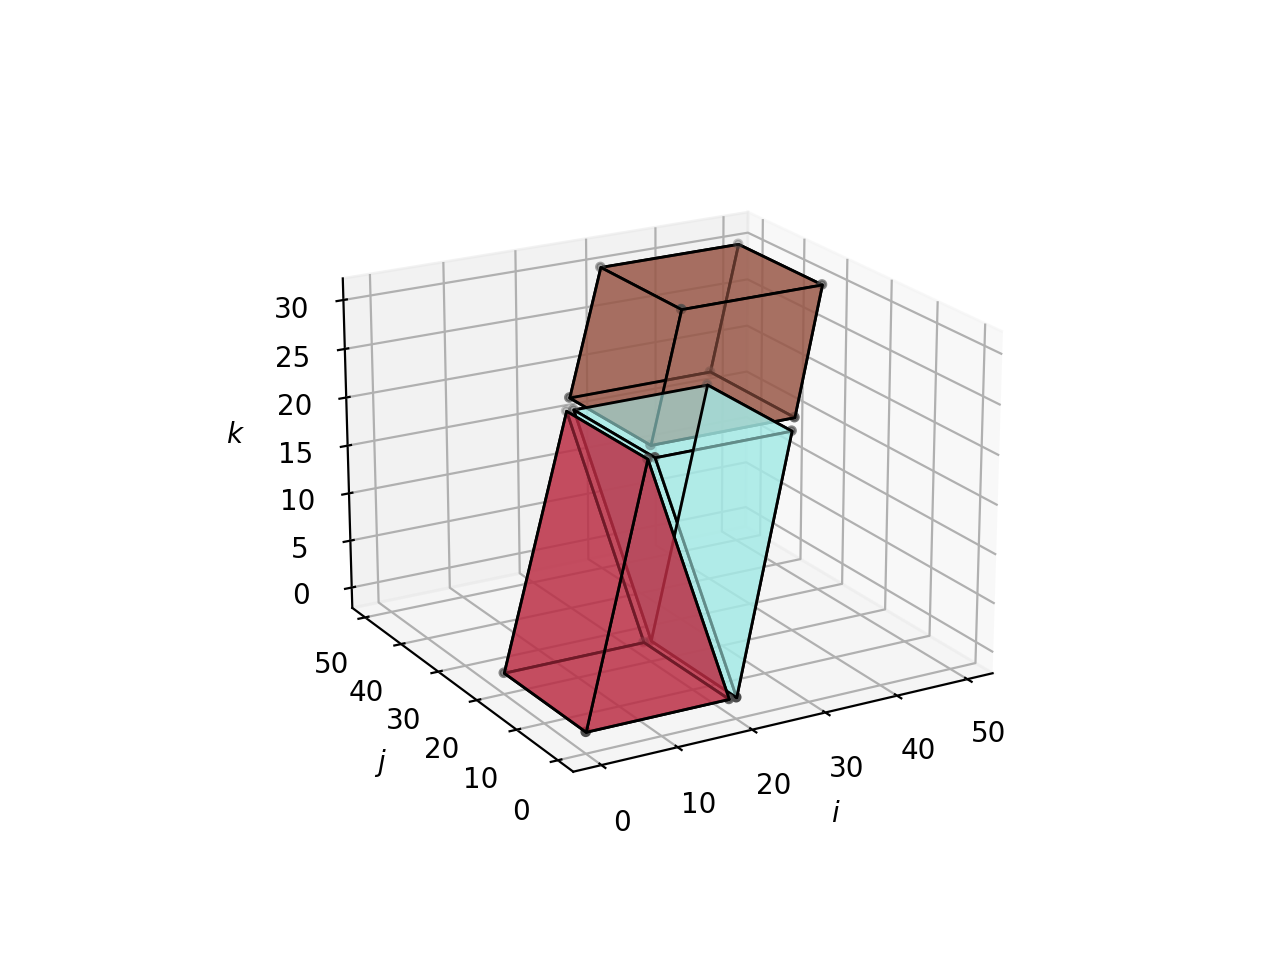

In [10]:
# 3D parallelpiped - v0
op = 'max'
fp = '{[i,j,k]->[i]}'
fd = '{[i,j,k]->[k]}'
s = '{[i,j,k] : k<=i,j<=20+k and 0<=k<=30}'

successes = start(op, fp, s, fd, verbose=False, report_all=False)

for success in successes:
    P = [p for p in success.get_splits(result=set())]
    plot_3d_sets(P)

## 9) 3D parallelpiped - parametric

constraints:
c0	[[ 0  0  1  0  0]	[N] -> { [i, j, k] : k >= 0 }
c1	 [-1  0  1  1  0]	[N] -> { [i, j, k] : N - i + k >= 0 }
c2	 [ 0 -1  1  1  0]	[N] -> { [i, j, k] : N - j + k >= 0 }
c3	 [ 0  1 -1  0  0]	[N] -> { [i, j, k] : j - k >= 0 }
c4	 [ 1  0 -1  0  0]	[N] -> { [i, j, k] : i - k >= 0 }
c5	 [ 0  0 -1  5  0]]	[N] -> { [i, j, k] : 5N - k >= 0 }

Simplifications
@{}:@{}, [N]->{[i,j,k]->[i]} :: Action.INDEX_SET_SPLIT at [N] -> { [i, j, k] -> [(-N + i)] }
  L.0@{}:@{}, [N]->{[i,j,k]->[i]} :: Action.DECOMPOSITION, [N]->{[i,j,k]->[-j + k,i]} on {4}
    @{}:@{}, [N]->{[i,j,k]->[-j + k,i]} :: Action.RHO, [N = 0] -> { [1, 0, 0] } 
      @{}:@{0}, [N]->{[i,j,k]->[-j + k,i]} :: Action.RHO, [N = 0] -> { [0, -1, 0] } 
        @{}:@{0, 3}, [N]->{[i,j,k]->[-j + k,i]} :: Action.NONE 
  R.0@{}:@{}, [N]->{[i,j,k]->[i]} :: Action.INDEX_SET_SPLIT at [N] -> { [i, j, k] -> [(-N + k)] }
    L.0@{}:@{}, [N]->{[i,j,k]->[i]} :: Action.DECOMPOSITION, [N]->{[i,j,k]->[-j + k,i]} on {4}
      @{}:@{}, [N]->{[i,j

<IPython.core.display.Javascript object>


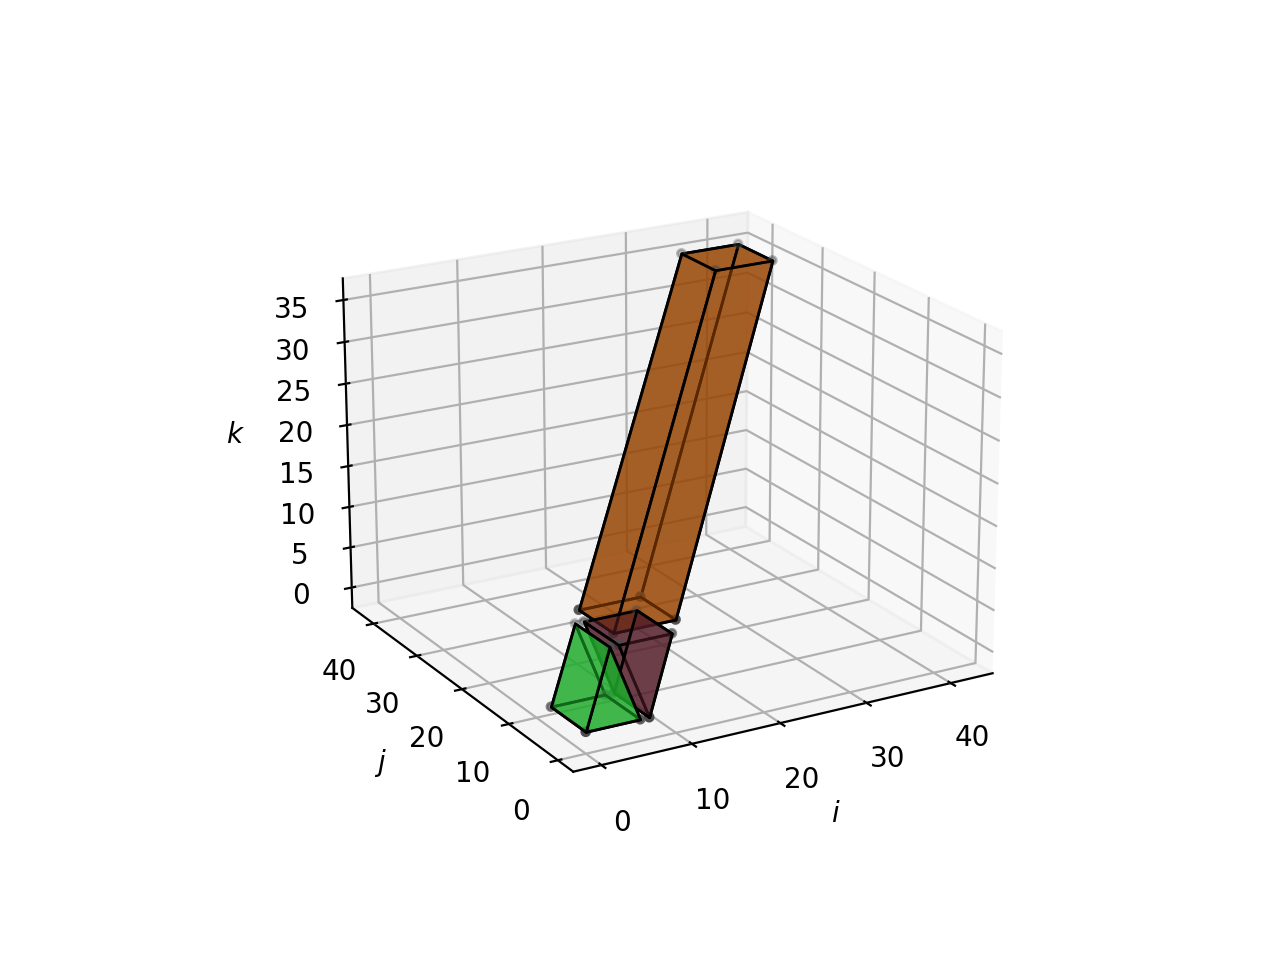

In [11]:
# 3D parallelpiped - v1
op = 'max'
fp = '[N]->{[i,j,k]->[i]}'
fd = '[N]->{[i,j,k]->[k]}'
s = '[N]->{[i,j,k] : k<=i,j<=N+k and 0<=k<=5N}'

# visulaization
dom = BasicSet('[N]->{[i,j,k] : N=7}')

successes = start(op, fp, s, fd, verbose=False, report_all=False)

for success in successes:
    P = [p.intersect(dom) for p in success.get_splits(result=set(), params=dom)]
    plot_3d_sets(P)

## 10) 3D parallelpiped - parametric + different projection function

constraints:
c0	[[ 0  0  1  0  0]	[N] -> { [i, j, k] : k >= 0 }
c1	 [-1  0  1  1  0]	[N] -> { [i, j, k] : N - i + k >= 0 }
c2	 [ 0 -1  1  1  0]	[N] -> { [i, j, k] : N - j + k >= 0 }
c3	 [ 0  1 -1  0  0]	[N] -> { [i, j, k] : j - k >= 0 }
c4	 [ 1  0 -1  0  0]	[N] -> { [i, j, k] : i - k >= 0 }
c5	 [ 0  0 -1  5  0]]	[N] -> { [i, j, k] : 5N - k >= 0 }

Simplifications
@{}:@{}, [N]->{[i,j,k]->[j-i]} :: Action.INDEX_SET_SPLIT at [N] -> { [i, j, k] -> [(-i + j)] }
  L.0@{}:@{}, [N]->{[i,j,k]->[j-i]} :: Action.RHO, [N = 0] -> { [-1, 1, 0] } 
    @{}:@{4}, [N]->{[i,j,k]->[j-i]} :: Action.RHO, [N = 0] -> { [-1, 0, 0] } 
      @{}:@{3, 4}, [N]->{[i,j,k]->[j-i]} :: Action.NONE 
  R.0@{}:@{}, [N]->{[i,j,k]->[j-i]} :: Action.RHO, [N = 0] -> { [1, -1, 0] } 
    @{}:@{4}, [N]->{[i,j,k]->[j-i]} :: Action.RHO, [N = 0] -> { [0, -1, 0] } 
      @{}:@{3, 4}, [N]->{[i,j,k]->[j-i]} :: Action.NONE 


<IPython.core.display.Javascript object>


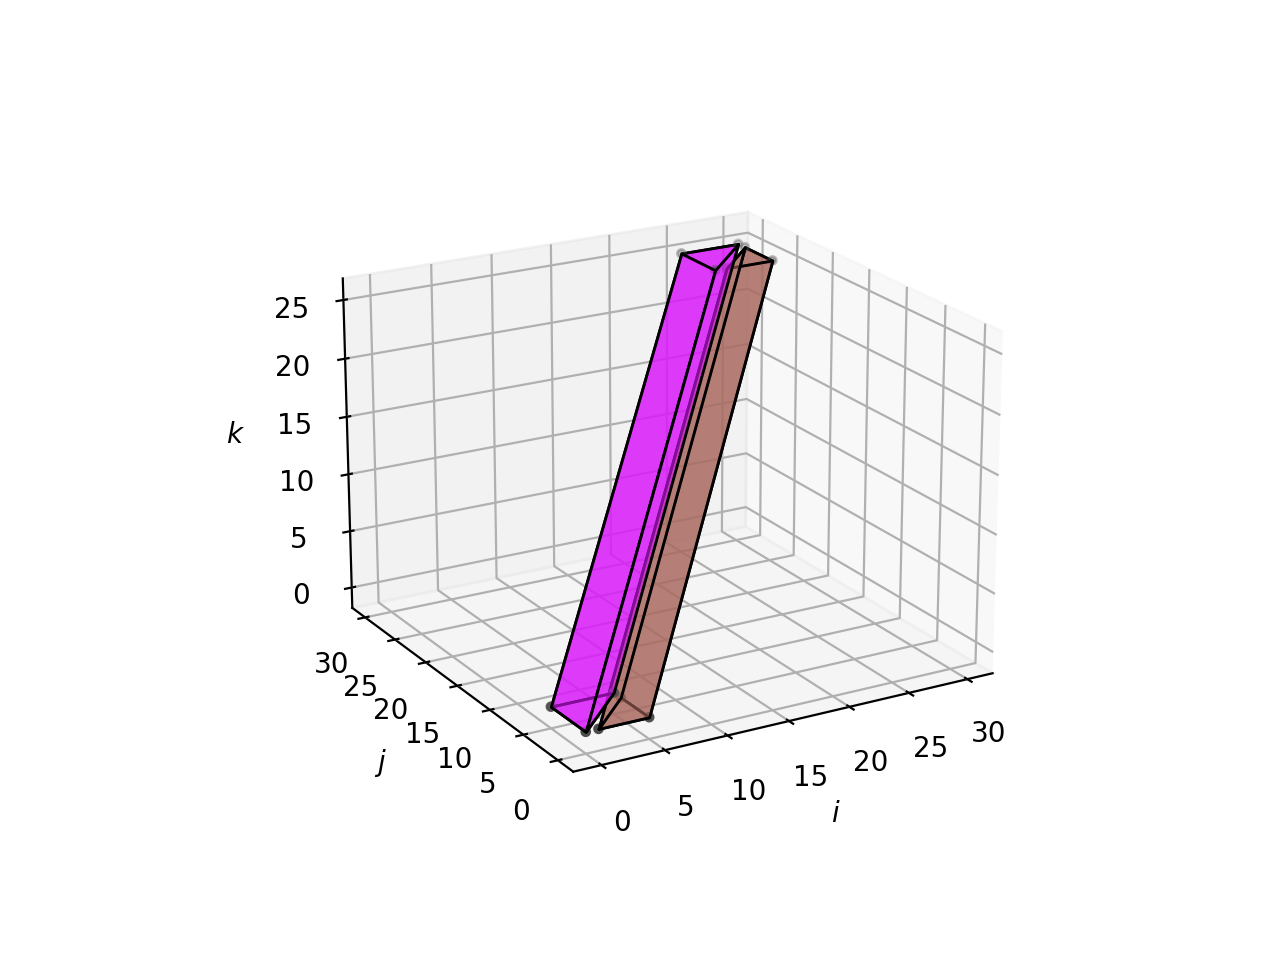

In [12]:
# 3D parallelpiped - v2
op = 'max'
fp = '[N]->{[i,j,k]->[j-i]}'
fd = '[N]->{[i,j,k]->[k]}'
s = '[N]->{[i,j,k] : k<=i,j<=N+k and 0<=k<=5N}'

# visulaization
dom = BasicSet('[N]->{[i,j,k] : N=5}')

successes = start(op, fp, s, fd, verbose=False, report_all=False)

for success in successes:
    P = [p.intersect(dom) for p in success.get_splits(result=set(), params=dom)]
    plot_3d_sets(P)

constraints:
c0	[[ 0  0  1  0  0]	[N] -> { [i, j, k] : k >= 0 }
c1	 [-1  0  1  1  0]	[N] -> { [i, j, k] : N - i + k >= 0 }
c2	 [ 0 -1  1  1  0]	[N] -> { [i, j, k] : N - j + k >= 0 }
c3	 [ 0  1 -1  0  0]	[N] -> { [i, j, k] : j - k >= 0 }
c4	 [ 1  0 -1  0  0]	[N] -> { [i, j, k] : i - k >= 0 }
c5	 [ 0  0 -1  5  0]]	[N] -> { [i, j, k] : 5N - k >= 0 }

Simplifications
@{}:@{}, [N]->{[i,j,k]->[i,j]} :: Action.INDEX_SET_SPLIT at [N] -> { [i, j, k] -> [(-N + j)] }
  L.0@{}:@{}, [N]->{[i,j,k]->[i,j]} :: Action.RHO, [N = 0] -> { [0, 1, 0] } 
    @{}:@{4}, [N]->{[i,j,k]->[i,j]} :: Action.RHO, [N = 0] -> { [-1, 0, 0] } 
      @{}:@{3, 4}, [N]->{[i,j,k]->[i,j]} :: Action.NONE 
  R.0@{}:@{}, [N]->{[i,j,k]->[i,j]} :: Action.INDEX_SET_SPLIT at [N] -> { [i, j, k] -> [(-N + k)] }
    L.0@{}:@{}, [N]->{[i,j,k]->[i,j]} :: Action.RHO, [N = 0] -> { [0, -1, 0] } 
      @{}:@{3}, [N]->{[i,j,k]->[i,j]} :: Action.RHO, [N = 0] -> { [-1, 0, 0] } 
        @{}:@{2, 3}, [N]->{[i,j,k]->[i,j]} :: Action.NONE 
    R.0@

<IPython.core.display.Javascript object>


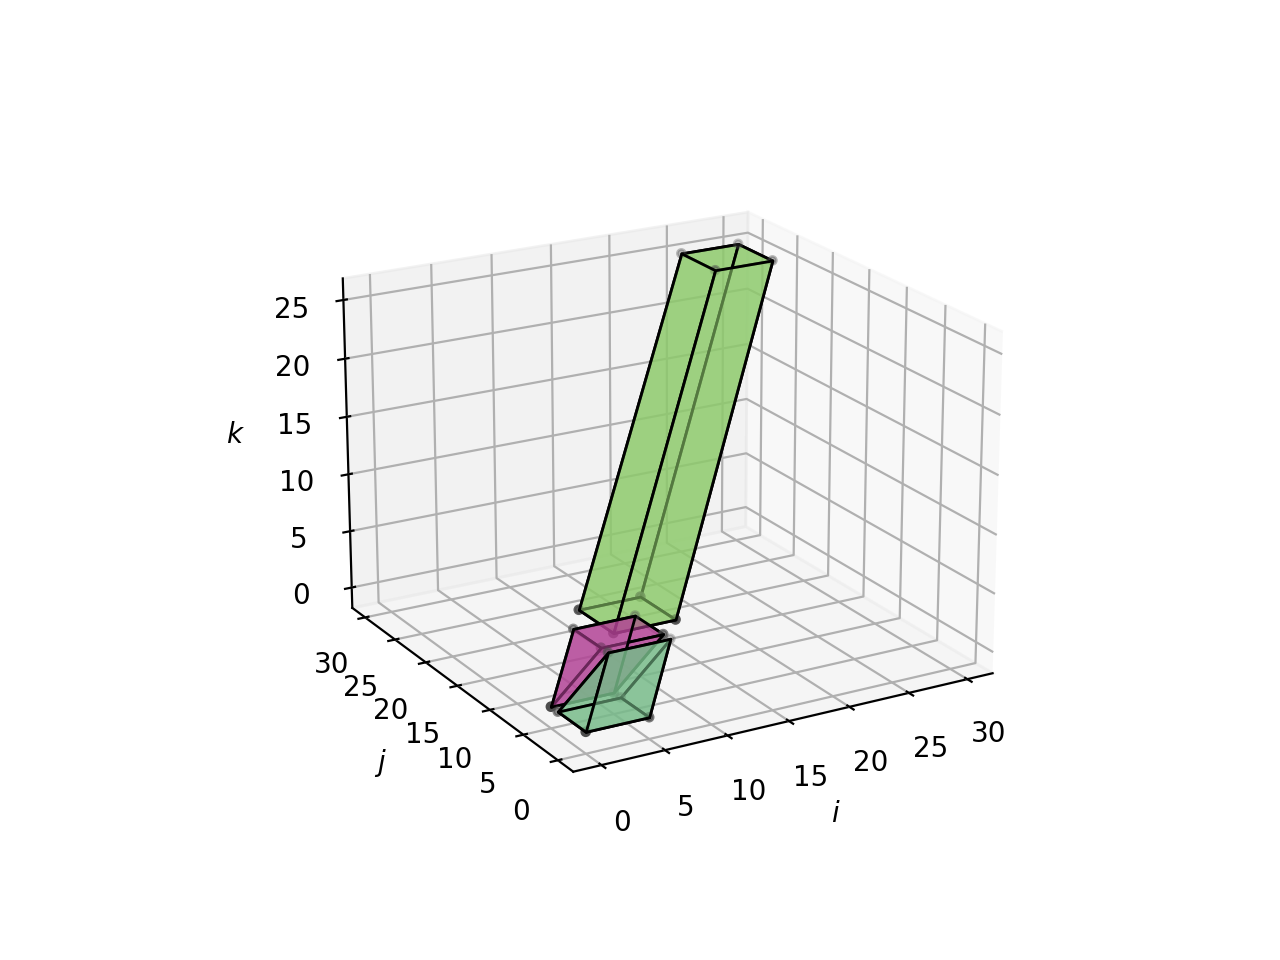

In [13]:
# 3D parallelpiped - v3
op = 'max'
fp = '[N]->{[i,j,k]->[i,j]}'
fd = '[N]->{[i,j,k]->[k]}'
s = '[N]->{[i,j,k] : k<=i,j<=N+k and 0<=k<=5N}'

# visulaization
dom = BasicSet('[N]->{[i,j,k] : N=5}')

successes = start(op, fp, s, fd, verbose=False, report_all=False)

for success in successes:
    P = [p.intersect(dom) for p in success.get_splits(result=set(), params=dom)]
    plot_3d_sets(P)

constraints:
c0	[[ 0  0  1  0  0  0]	[M, N] -> { [i, j, k] : k >= 0 }
c1	 [-1  0  1  0  1  0]	[M, N] -> { [i, j, k] : N - i + k >= 0 }
c2	 [ 0 -1  1  0  1  0]	[M, N] -> { [i, j, k] : N - j + k >= 0 }
c3	 [ 0  1 -1  0  0  0]	[M, N] -> { [i, j, k] : j - k >= 0 }
c4	 [ 1  0 -1  0  0  0]	[M, N] -> { [i, j, k] : i - k >= 0 }
c5	 [ 0  0 -1  1  0  0]]	[M, N] -> { [i, j, k] : M - k >= 0 }

Simplifications
@{}:@{}, [M,N]->{[i,j,k]->[i,j]} :: Action.INDEX_SET_SPLIT at [M, N] -> { [i, j, k] -> [(-N + j)] }
  L.0@{}:@{}, [M,N]->{[i,j,k]->[i,j]} :: Action.RHO, [M = 0, N = 0] -> { [0, 1, 0] } 
    @{}:@{4}, [M,N]->{[i,j,k]->[i,j]} :: Action.RHO, [M = 0, N = 0] -> { [-1, 0, 0] } 
      @{}:@{3, 4}, [M,N]->{[i,j,k]->[i,j]} :: Action.NONE 
  L.1@{}:@{}, [M,N]->{[i,j,k]->[i,j]} :: Action.RHO, [M = 0, N = 0] -> { [0, 1, 0] } 
    @{}:@{4}, [M,N]->{[i,j,k]->[i,j]} :: Action.RHO, [M = 0, N = 0] -> { [-1, 0, 0] } 
      @{}:@{3, 4}, [M,N]->{[i,j,k]->[i,j]} :: Action.NONE 
  R.0@{}:@{}, [M,N]->{[i,j,k]->[i,j

<IPython.core.display.Javascript object>


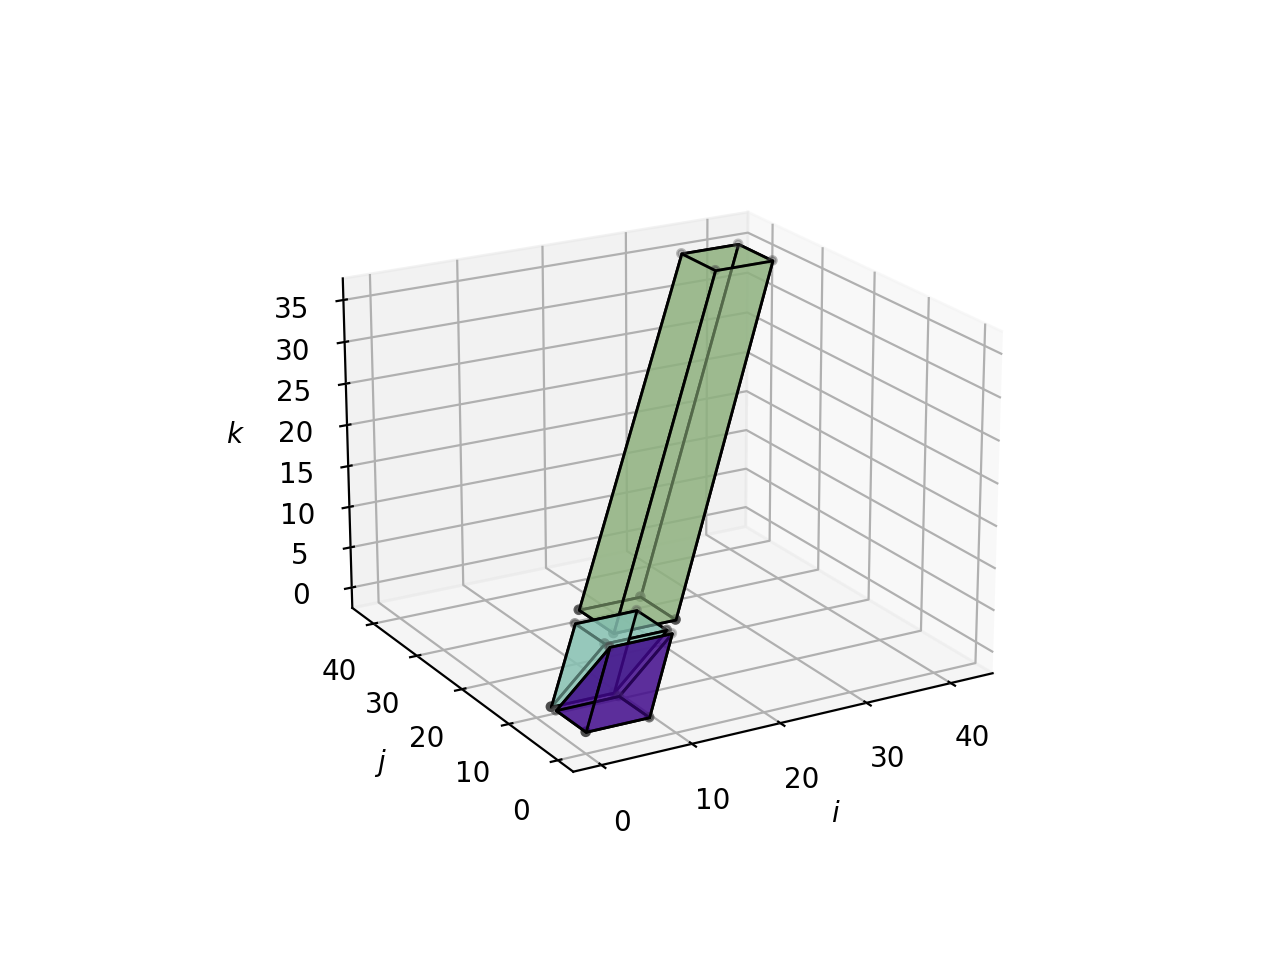

In [14]:
# 3D parallelpiped - v4
op = 'max'
fp = '[M,N]->{[i,j,k]->[i,j]}'
fd = '[M,N]->{[i,j,k]->[k]}'
s = '[M,N]->{[i,j,k] : k<=i,j<=N+k and 0<=k<=M}'

# visulaization
dom = BasicSet('[M,N]->{[i,j,k] : N=7 and M=35}')

successes = start(op, fp, s, fd, verbose=False, report_all=False)

for success in successes:
    P = [p.intersect(dom) for p in success.get_splits(result=set(), params=dom)]
    plot_3d_sets(P)

Observations:
* we don't need a similarity check for the constant case (or even single parameter case), since this will ALWAYS terminate -- there are a finite number of cuts that need to be made.